In [ ]:
import pandas as pd
import numpy as np
from lifelines import CoxTimeVaryingFitter

from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score



In [14]:
def get_first_target_times(df, patient_col="ID", time_col="Month", targets=["event_vl50", "event_vl200", "event_cd4"]):
    """
    Finds the first time each patient reaches the given targets.

    Parameters:
    - df (pd.DataFrame): Original DataFrame with patient data.
    - patient_col (str): Name of the patient ID column.
    - time_col (str): Name of the time column.
    - targets (list): List of target event columns to check.

    Returns:
    - pd.DataFrame: A DataFrame containing Patient ID and first time they hit each target.
    """
    result_df = pd.DataFrame()

    # Loop through each target and find first occurrence
    for target in targets:
        first_times = df[df[target] == 1].groupby(patient_col)[time_col].min().reset_index()
        first_times.rename(columns={time_col: f"first_{target}"}, inplace=True)
        
        # Merge into result DataFrame
        if result_df.empty:
            result_df = first_times
        else:
            result_df = result_df.merge(first_times, on=patient_col, how="outer")

    return result_df

In [ ]:
df = pd.read_csv('BDHSC_SCC_2025_synth_data.csv')

# Map codes to drug names using the data dictionary
drug_mappings = {
    'Base_Drug_Combo': {
        0: 'FTC + TDF',
        1: '3TC + ABC',
        2: 'FTC + TAF',
        3: 'DRV + FTC + TDF',
        4: 'FTC + RTVB + TDF',
        5: 'Other'
    },
    'Comp_INI': {0: 'DTG', 1: 'RAL', 2: 'EVG', 3: 'N/A'},
    'Comp_NNRTI': {0: 'NVP', 1: 'EFV', 2: 'RPV', 3: 'N/A'},
    'ExtraPI': {0: 'DRV', 1: 'RTVB', 2: 'LPV', 3: 'RTV', 4: 'ATV', 5: 'N/A'},
}

def map_regimen(row):
    """Combine regimen components into a standardized name."""
    base = drug_mappings['Base_Drug_Combo'].get(row['Base_Drug_Combo'], 'Unknown')
    ini = drug_mappings['Comp_INI'].get(row['Comp_INI'], '')
    nnrti = drug_mappings['Comp_NNRTI'].get(row['Comp_NNRTI'], '')
    pi = drug_mappings['ExtraPI'].get(row['ExtraPI'], '')
    enhancer = ' + ExtraPK' if row['ExtraPk_En'] == 1 else ''
    components = [base, ini, nnrti, pi]
    regimen = ' + '.join(filter(None, components)) + enhancer
    return regimen

# Create regimen name for each time point
df['Regimen'] = df.apply(map_regimen, axis=1)

df['event_vl50'] = df['VL'] < 50
df['event_vl250'] = df['VL'] < 250
df['event_cd4'] = df['CD4'] > 500

In [16]:
targets = ["event_vl50", "event_vl250", "event_cd4"]  # Modify as needed
first_target_times_df = get_first_target_times(df, targets=targets)

In [18]:
df = pd.merge(df, first_target_times_df, on='ID', how='inner')
df

,ID,Month,Gender,Ethnic,Base_Drug_Combo,Comp_INI,Comp_NNRTI,ExtraPI,ExtraPk_En,VL_M,...,VL,CD4,RelCD4,Regimen,event_vl50,event_vl250,event_cd4,first_event_vl50,first_event_vl250,first_event_cd4
0,8130128040812561626,0,1,3,0,0,3,5,0,0,...,29.944271,793.458300,30.834505,FTC + TDF + DTG + N/A + N/A,True,True,True,0.0,0.0,0.0
1,8130128040812561626,1,1,3,0,0,3,5,0,0,...,29.241980,467.418900,30.355980,FTC + TDF + DTG + N/A + N/A,True,True,False,0.0,0.0,0.0
2,8130128040812561626,2,1,3,0,0,3,5,0,0,...,28.748991,465.124850,30.405320,FTC + TDF + DTG + N/A + N/A,True,True,False,0.0,0.0,0.0
3,8130128040812561626,3,1,3,0,0,3,5,0,0,...,28.101835,692.006900,30.248816,FTC + TDF + DTG + N/A + N/A,True,True,True,0.0,0.0,0.0
4,8130128040812561626,4,1,3,0,0,3,5,0,0,...,28.813837,641.757140,29.944712,FTC + TDF + DTG + N/A + N/A,True,True,True,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11231155,18117203277056921559,55,1,4,0,2,3,5,1,0,...,8.454356,4045.386412,37.574126,FTC + TDF + EVG + N/A + N/A + ExtraPK,True,True,True,36.0,36.0,0.0
11231156,18117203277056921559,56,1,4,0,2,3,5,1,0,...,110.025330,2685.636079,23.047465,FTC + TDF + EVG + N/A + N/A + ExtraPK,False,True,True,36.0,36.0,0.0
11231157,18117203277056921559,57,1,4,0,2,3,5,1,0,...,9.441938,3689.274170,38.173028,FTC + TDF + EVG + N/A + N/A + ExtraPK,True,True,True,36.0,36.0,0.0
11231158,18117203277056921559,58,1,4,0,2,3,5,1,0,...,18.851511,2755.832797,30.159213,FTC + TDF + EVG + N/A + N/A + ExtraPK,True,True,True,36.0,36.0,0.0


In [19]:
df_sorted = df.sort_values(['ID', 'Month'])
df_sorted['Regimen_Shift'] = (df_sorted.groupby('ID')['Regimen'].shift() != df_sorted['Regimen']).astype(int)
df_sorted['Regimen_Start'] = df_sorted.groupby('ID')['Regimen_Shift'].cumsum()
df_sorted

,ID,Month,Gender,Ethnic,Base_Drug_Combo,Comp_INI,Comp_NNRTI,ExtraPI,ExtraPk_En,VL_M,...,RelCD4,Regimen,event_vl50,event_vl250,event_cd4,first_event_vl50,first_event_vl250,first_event_cd4,Regimen_Shift,Regimen_Start
7026060,30133543973798,0,2,4,0,1,3,5,0,0,...,16.563809,FTC + TDF + RAL + N/A + N/A,False,False,True,37.0,37.0,0.0,1,1
7026061,30133543973798,1,2,4,0,1,3,5,0,0,...,15.882227,FTC + TDF + RAL + N/A + N/A,False,False,False,37.0,37.0,0.0,0,1
7026062,30133543973798,2,2,4,0,1,3,5,0,0,...,15.353022,FTC + TDF + RAL + N/A + N/A,False,False,False,37.0,37.0,0.0,0,1
7026063,30133543973798,3,2,4,0,1,3,5,0,0,...,15.360681,FTC + TDF + RAL + N/A + N/A,False,False,False,37.0,37.0,0.0,0,1
7026064,30133543973798,4,2,4,0,1,3,5,0,0,...,15.164561,FTC + TDF + RAL + N/A + N/A,False,False,False,37.0,37.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4573255,18446621368945950104,55,1,4,1,0,3,5,0,0,...,43.276831,3TC + ABC + DTG + N/A + N/A,True,True,True,35.0,35.0,0.0,0,1
4573256,18446621368945950104,56,1,4,1,0,3,5,0,0,...,67.081246,3TC + ABC + DTG + N/A + N/A,True,True,True,35.0,35.0,0.0,0,1
4573257,18446621368945950104,57,1,4,1,0,3,5,0,0,...,42.229204,3TC + ABC + DTG + N/A + N/A,True,True,True,35.0,35.0,0.0,0,1
4573258,18446621368945950104,58,1,4,1,0,3,5,0,0,...,45.691500,3TC + ABC + DTG + N/A + N/A,True,True,True,35.0,35.0,0.0,0,1


In [29]:
# Split into regimen intervals
intervals = df_sorted.groupby(['ID', 'Regimen_Start']).agg(
    Start=('Month', 'min'),
    End=('Month', 'max'),
    Regimen=('Regimen', 'first'),
    VL=('VL', lambda x: list(x)),
    CD4=('CD4', lambda x: list(x)),
    VL_50_time=('first_event_vl50', 'first'),
    VL_250_time=('first_event_vl250', 'first'),
    CD4_500_time=('first_event_cd4', 'first'),
    Gender=('Gender', 'first'),
    Ethnicity=('Ethnic', 'first'),
    VL_50_baseline=('VL', 'first'),
    CD4_500_baseline=('CD4', 'first'),
    CD4_Percent_baseline=('RelCD4', 'first')
).reset_index()
intervals

,ID,Regimen_Start,Start,End,Regimen,VL,CD4,VL_50_time,VL_250_time,CD4_500_time,Gender,Ethnicity,VL_50_baseline,CD4_500_baseline,CD4_Percent_baseline
0,30133543973798,1,0,36,FTC + TDF + RAL + N/A + N/A,"[93638.8562718528, 77667.8810743248, 83949.839...","[920.18576905839, 160.734405273952, 383.350510...",37.0,37.0,0.0,2,4,93638.856272,920.185769,16.563809
1,30133543973798,2,37,39,FTC + TDF + EVG + N/A + N/A + ExtraPK,"[9.55248228406145, 4.72414052546108, 7.1883498...","[7005.38485742907, 3065.40266762323, 5451.3099...",37.0,37.0,0.0,2,4,9.552482,7005.384857,162.865539
2,30133543973798,3,40,40,FTC + TAF + EVG + N/A + N/A + ExtraPK,[4.94591964622396],[3327.85476220719],37.0,37.0,0.0,2,4,4.945920,3327.854762,83.388706
3,30133543973798,4,41,44,FTC + TDF + EVG + N/A + N/A + ExtraPK,"[6.31118919688667, 6.83768487198906, 5.9766095...","[3024.13385676058, 3377.70865507836, 6248.8481...",37.0,37.0,0.0,2,4,6.311189,3024.133857,117.538874
4,30133543973798,5,45,45,FTC + TDF + RAL + N/A + N/A,[79673.3752108363],[268.807228546071],37.0,37.0,0.0,2,4,79673.375211,268.807229,15.079007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766948,18446335763543073043,1,0,28,DRV + FTC + TDF + N/A + N/A + RTVB,"[249.331672373449, 958.275330079404, 615.51133...","[277.662502670911, 239.406528059982, 254.94597...",16.0,0.0,18.0,2,4,249.331672,277.662503,17.700144
1766949,18446335763543073043,2,29,29,FTC + RTVB + TDF + N/A + N/A + RTVB,[15.710728181727],[556.094498455246],16.0,0.0,18.0,2,4,15.710728,556.094498,26.306106
1766950,18446335763543073043,3,30,34,DRV + FTC + TDF + N/A + N/A + RTVB,"[18.4384976003903, 53.4209643759377, 45.893684...","[365.294939888206, 348.306891626308, 362.94657...",16.0,0.0,18.0,2,4,18.438498,365.294940,20.565518
1766951,18446335763543073043,4,35,59,FTC + TDF + N/A + RPV + N/A,"[20.4950353636524, 42.6254523262086, 18.274370...","[580.429057162937, 381.982937609459, 537.70112...",16.0,0.0,18.0,2,4,20.495035,580.429057,31.043593


In [30]:
intervals_censored = intervals.copy()
intervals_censored['VL_50_Censored'] = np.where(
    ~((intervals_censored['Start'] <= intervals_censored['VL_50_time']) & 
      (intervals_censored['VL_50_time'] <= intervals_censored['End'])),
    True,  # If the condition is not met, mark as censored (True)
    False  # Otherwise, mark as not censored (False)
)
intervals_censored['VL_250_Censored'] = np.where(
    ~((intervals_censored['Start'] <= intervals_censored['VL_250_time']) & 
      (intervals_censored['VL_250_time'] <= intervals_censored['End'])),
    True,  # If the condition is not met, mark as censored (True)
    False  # Otherwise, mark as not censored (False)
)
intervals_censored['CD4_500_Censored'] = np.where(
    ~((intervals_censored['Start'] <= intervals_censored['CD4_500_time']) & 
      (intervals_censored['CD4_500_time'] <= intervals_censored['End'])),
    True,  # If the condition is not met, mark as censored (True)
    False  # Otherwise, mark as not censored (False)
)
intervals_censored


,ID,Regimen_Start,Start,End,Regimen,VL,CD4,VL_50_time,VL_250_time,CD4_500_time,Gender,Ethnicity,VL_50_baseline,CD4_500_baseline,CD4_Percent_baseline,VL_50_Censored,VL_250_Censored,CD4_500_Censored
0,30133543973798,1,0,36,FTC + TDF + RAL + N/A + N/A,"[93638.8562718528, 77667.8810743248, 83949.839...","[920.18576905839, 160.734405273952, 383.350510...",37.0,37.0,0.0,2,4,93638.856272,920.185769,16.563809,True,True,False
1,30133543973798,2,37,39,FTC + TDF + EVG + N/A + N/A + ExtraPK,"[9.55248228406145, 4.72414052546108, 7.1883498...","[7005.38485742907, 3065.40266762323, 5451.3099...",37.0,37.0,0.0,2,4,9.552482,7005.384857,162.865539,False,False,True
2,30133543973798,3,40,40,FTC + TAF + EVG + N/A + N/A + ExtraPK,[4.94591964622396],[3327.85476220719],37.0,37.0,0.0,2,4,4.945920,3327.854762,83.388706,True,True,True
3,30133543973798,4,41,44,FTC + TDF + EVG + N/A + N/A + ExtraPK,"[6.31118919688667, 6.83768487198906, 5.9766095...","[3024.13385676058, 3377.70865507836, 6248.8481...",37.0,37.0,0.0,2,4,6.311189,3024.133857,117.538874,True,True,True
4,30133543973798,5,45,45,FTC + TDF + RAL + N/A + N/A,[79673.3752108363],[268.807228546071],37.0,37.0,0.0,2,4,79673.375211,268.807229,15.079007,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766948,18446335763543073043,1,0,28,DRV + FTC + TDF + N/A + N/A + RTVB,"[249.331672373449, 958.275330079404, 615.51133...","[277.662502670911, 239.406528059982, 254.94597...",16.0,0.0,18.0,2,4,249.331672,277.662503,17.700144,False,False,False
1766949,18446335763543073043,2,29,29,FTC + RTVB + TDF + N/A + N/A + RTVB,[15.710728181727],[556.094498455246],16.0,0.0,18.0,2,4,15.710728,556.094498,26.306106,True,True,True
1766950,18446335763543073043,3,30,34,DRV + FTC + TDF + N/A + N/A + RTVB,"[18.4384976003903, 53.4209643759377, 45.893684...","[365.294939888206, 348.306891626308, 362.94657...",16.0,0.0,18.0,2,4,18.438498,365.294940,20.565518,True,True,True
1766951,18446335763543073043,4,35,59,FTC + TDF + N/A + RPV + N/A,"[20.4950353636524, 42.6254523262086, 18.274370...","[580.429057162937, 381.982937609459, 537.70112...",16.0,0.0,18.0,2,4,20.495035,580.429057,31.043593,True,True,True


In [ ]:
def track_outcomes(group):
    """Track first suppression/CD4 recovery and retain covariates."""
    vl = group['VL']
    cd4 = group['CD4']
    time_points = group['Month']
    
    # Viral load outcomes
    vl_250_time = next((t for t, val in zip(time_points, vl) if val <= 250), None)
    vl_50_time = next((t for t, val in zip(time_points, vl) if val <= 50), None)
    
    # CD4 recovery
    cd4_500_time = next((t for t, val in zip(time_points, cd4) if val > 500), None)
    
    return pd.Series({
        'VL_250_time': group['VL_250_time'].iloc[0] if 
        'VL_50_time': vl_50_time,
        'CD4_500_time': cd4_500_time,
        'VL_250_Censored': 1 if vl_250_time is None else 0,
        'VL_50_Censored': 1 if vl_50_time is None else 0,
        'CD4_500_Censored': 1 if cd4_500_time is None else 0,
        'Gender': group['Gender'].iloc[0],  # Add baseline covariates
        'Ethnicity': group['Ethnic'].iloc[0],
        'Baseline_VL': group['VL'].iloc[0],
        'Baseline_CD4': group['CD4'].iloc[0],
        'Baseline_CD4_percent': group['RelCD4']
    })

# Apply outcome tracking
outcomes = df_sorted.groupby(['ID']).apply(track_outcomes).reset_index()
intervals_outcomes = pd.merge(intervals, outcomes, on=['ID', 'Regimen_Start'])

In [ ]:
list(intervals_outcomes.iloc[0]['Baseline_CD4_percent'])[0]

In [89]:
def filter_intervals(df, mode):
    """Filter intervals where start time < target time (or target not achieved)."""

    if mode == 'vl50':
        mask = (df['Start'] < df['VL_50_time'])
    elif mode == 'vl250':
        mask = (df['Start'] < df['VL_250_time'])
    else:
        mask = (df['Start'] < df['CD4_500_time'])
    df = df[mask]
    return df[df['End'] - df['Start'] >= 6]

def cox(mode, verbose=False):
    filtered_intervals_outcomes = filter_intervals(intervals_censored, mode)

    tv_data = []
    for _, row in filtered_intervals_outcomes.iterrows():
        start = row['Start']
        if mode == 'vl50':
            end = row['End'] if row['VL_50_Censored'] == 1 else row['VL_50_time']
        elif mode == 'vl250':
            end = row['End'] if row['VL_250_Censored'] == 1 else row['VL_250_time']
        else:
            end = row['End'] if row['CD4_500_Censored'] == 1 else row['CD4_500_time']
        
        tv_data.append({
            'Patient ID': row['ID'],
            'start': start,
            'stop': end,
            'gender': row['Gender'],
            'ethnicity': row['Ethnicity'],
            'censor': row['VL_50_Censored'] if mode == 'vl50' else row['VL_250_Censored'] if mode == 'vl250' else row['CD4_500_Censored'],
            'Regimen': row['Regimen'],
            'Baseline_VL': row['VL_50_baseline'],
            'Baseline_CD4': row['CD4_500_baseline'],
            'Baseline_CD4_Percent': row['CD4_Percent_baseline']
        })

    tv_df = pd.DataFrame(tv_data)
    counts = tv_df["Regimen"].value_counts()
    common_regimens = counts[counts > 1000].index

    tv_df["Regimen"] = tv_df["Regimen"].apply(
        lambda x: x if x in common_regimens else "Other"
    )

    tv_df["gender"] = tv_df["gender"].astype("category")
    # tv_df["ethnicity"] = tv_df["ethnicity"].astype("category")
    tv_df = pd.get_dummies(tv_df, columns=["Regimen", "gender"], drop_first=True)

    # tv_df.drop(['Regimen'], axis=1, inplace=True)

    ctv = CoxTimeVaryingFitter()
    ctv.fit(
        tv_df,
        id_col="Patient ID",
        event_col="censor",
        start_col="start",
        stop_col="stop",
        show_progress=True
    )
    if verbose:
        ctv.print_summary()
    return ctv, common_regimens

In [90]:
ctv_vl50, common_regimens_vl50 = cox('vl50')
ctv_vl250,  common_regimens_vl250= cox('vl250')
ctv_cd4_500 , common_regimens_cd4_500= cox('cd4_500')

Iteration 1: norm_delta = 1.36e+00, step_size = 0.9500, log_lik = -410010.76973, newton_decrement = 1.41e+04, seconds_since_start = 0.8
Iteration 2: norm_delta = 5.34e-01, step_size = 0.9500, log_lik = -400441.91760, newton_decrement = 2.98e+03, seconds_since_start = 1.9
Iteration 3: norm_delta = 4.18e-02, step_size = 0.9500, log_lik = -397399.94974, newton_decrement = 5.68e+01, seconds_since_start = 2.9
Iteration 4: norm_delta = 3.68e-03, step_size = 1.0000, log_lik = -397341.84451, newton_decrement = 5.96e-01, seconds_since_start = 3.7
Iteration 5: norm_delta = 4.02e-05, step_size = 1.0000, log_lik = -397341.24455, newton_decrement = 7.46e-05, seconds_since_start = 4.8
Iteration 6: norm_delta = 5.76e-09, step_size = 1.0000, log_lik = -397341.24448, newton_decrement = 1.65e-12, seconds_since_start = 5.7
Convergence completed after 6 iterations.
Iteration 1: norm_delta = 1.50e+00, step_size = 0.9500, log_lik = -284991.06996, newton_decrement = 1.24e+04, seconds_since_start = 0.6
Iterat

In [91]:
ctv_vl50.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
ethnicity,7.235558e-02,1.075038,9.862861e-03,0.053025,0.091686,1.054456,1.096021,0.0,7.336166,2.198002e-13,42.048873
Baseline_VL,2.234189e-06,1.000002,1.975571e-07,0.000002,0.000003,1.000002,1.000003,0.0,11.309080,1.183238e-29,96.093175
Baseline_CD4,6.068481e-07,1.000001,7.279237e-06,-0.000014,0.000015,0.999986,1.000015,0.0,0.083367,9.335597e-01,0.099186
Baseline_CD4_Percent,-4.259546e-03,0.995750,5.054217e-04,-0.005250,-0.003269,0.994764,0.996736,0.0,-8.427706,3.525065e-17,54.655128
Regimen_3TC + ABC + N/A + N/A + DRV,2.769204e+00,15.945928,6.095487e-02,2.649734,2.888673,14.150277,17.969446,0.0,45.430391,0.000000e+00,inf
Regimen_3TC + ABC + N/A + NVP + N/A,1.950647e-01,1.215390,7.650720e-02,0.045113,0.345016,1.046146,1.412013,0.0,2.549626,1.078385e-02,6.534984
Regimen_3TC + ABC + RAL + N/A + N/A,2.362600e+00,10.618526,3.402935e-02,2.295904,2.429297,9.933411,11.350894,0.0,69.428304,0.000000e+00,inf
Regimen_DRV + FTC + TDF + N/A + N/A + RTV,2.196568e+00,8.994096,4.722074e-02,2.104017,2.289119,8.199043,9.866245,0.0,46.517028,0.000000e+00,inf
Regimen_DRV + FTC + TDF + N/A + N/A + RTVB,2.010952e+00,7.470429,2.895732e-02,1.954197,2.067708,7.058250,7.906678,0.0,69.445403,0.000000e+00,inf


In [74]:
ctv_vl250.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
ethnicity,0.138422,1.148460,1.235449e-02,0.114207,0.162636,1.120985,1.176608,0.0,11.204165,3.890067e-29,94.376120
Baseline_VL,0.000003,1.000003,2.437335e-07,0.000003,0.000004,1.000003,1.000004,0.0,12.576408,2.846830e-36,118.080055
Baseline_CD4,-0.000165,0.999835,1.044010e-05,-0.000185,-0.000144,0.999815,0.999856,0.0,-15.764059,5.498525e-56,183.568929
Baseline_CD4_Percent,0.011897,1.011968,5.863883e-04,0.010748,0.013046,1.010806,1.013132,0.0,20.288393,1.628312e-91,301.592080
Regimine_3TC + ABC + N/A + N/A + DRV,3.298479,27.071436,8.635237e-02,3.129232,3.467727,22.856410,32.063768,0.0,38.197900,0.000000e+00,inf
Regimine_3TC + ABC + N/A + NVP + N/A,0.775100,2.170809,1.007474e-01,0.577638,0.972561,1.781826,2.644709,0.0,7.693495,1.431694e-14,45.989271
Regimine_3TC + ABC + RAL + N/A + N/A,2.387067,10.881527,3.553852e-02,2.317412,2.456721,10.149377,11.666492,0.0,67.168431,0.000000e+00,inf
Regimine_DRV + FTC + TDF + N/A + N/A + RTV,1.504282,4.500922,5.349488e-02,1.399434,1.609130,4.052906,4.998462,0.0,28.120117,5.561073e-174,575.540125
Regimine_DRV + FTC + TDF + N/A + N/A + RTVB,2.074534,7.960837,3.132255e-02,2.013143,2.135925,7.486812,8.464875,0.0,66.231327,0.000000e+00,inf


In [94]:
ctv_cd4_500.summary.reset_index()[['covariate', 'exp(coef)', 'p']].to_csv('cd4.csv')

In [95]:
summary1 = ctv_vl50.summary
summary2 = ctv_vl250.summary
summary3 = ctv_cd4_500.summary

high_risk_1 = set(summary1[summary1["exp(coef)"] > 2].index)
high_risk_2 = set(summary2[summary2["exp(coef)"] > 2].index)
high_risk_3 = set(summary3[summary3["exp(coef)"] > 2].index)

# Find predictors that meet the criterion in all three models
common_high_risk = high_risk_1 & high_risk_2 & high_risk_3
# common_high_risk = high_risk_1 & high_risk_2

# Convert to a sorted list
common_high_risk = sorted(common_high_risk)

# Display results
exp_coef_df = pd.DataFrame({
    "Predictor": common_high_risk,
    "Model 1 exp(coef)": [summary1.loc[p, "exp(coef)"] for p in common_high_risk],
    "Model 2 exp(coef)": [summary2.loc[p, "exp(coef)"] for p in common_high_risk],
    "Model 3 exp(coef)": [summary3.loc[p, "exp(coef)"] for p in common_high_risk]
})

exp_coef_df


,Predictor,Model 1 exp(coef),Model 2 exp(coef),Model 3 exp(coef)
0,Regimen_DRV + FTC + TDF + N/A + N/A + RTVB,7.470429,7.960837,2.918876
1,Regimen_FTC + RTVB + TDF + N/A + N/A + ATV,8.645640,10.495366,4.175325
2,Regimen_FTC + TDF + N/A + EFV + N/A,9.909704,13.971815,4.261119
3,Regimen_Other,16.805659,19.846657,6.445817


In [184]:
exp_coef_df.to_csv('combined.csv')

In [119]:
def km(mode):
    filtered_intervals_outcomes = filter_intervals(intervals_censored, mode)

    tv_data = []
    for _, row in filtered_intervals_outcomes.iterrows():
        start = row['Start']
        if mode == 'vl50':
            end = row['End'] if row['VL_50_Censored'] == 1 else row['VL_50_time']
        elif mode == 'vl250':
            end = row['End'] if row['VL_250_Censored'] == 1 else row['VL_250_time']
        else:
            end = row['End'] if row['CD4_500_Censored'] == 1 else row['CD4_500_time']
        
        tv_data.append({
            'Patient ID': row['ID'],
            'start': start,
            'stop': end,
            'gender': row['Gender'],
            'ethnicity': row['Ethnicity'],
            'censor': row['VL_50_Censored'] if mode == 'vl50' else row['VL_250_Censored'] if mode == 'vl250' else row['CD4_500_Censored'],
            'Regimen': row['Regimen'],
            'Baseline_VL': row['VL_50_baseline'],
            'Baseline_CD4': row['CD4_500_baseline'],
            'Baseline_CD4_Percent': row['CD4_Percent_baseline']
        })

    tv_df = pd.DataFrame(tv_data)
    tv_df[tv_df.select_dtypes(bool).columns] = tv_df.select_dtypes(bool).astype(int)

    
    top_regimens = ['DRV + FTC + TDF + N/A + N/A + RTVB', 'FTC + RTVB + TDF + N/A + N/A + ATV', 'FTC + TDF + N/A + EFV + N/A']

    # Initialize Kaplan-Meier Fitter
    kmf = KaplanMeierFitter()

    # Plot survival curves for the top 3 regimens
    plt.figure(figsize=(10, 6))
    for regimen in top_regimens:
        mask = tv_df['Regimen'] == regimen
        kmf.fit(tv_df['stop'][mask], event_observed=tv_df['censor'][mask], label=regimen)
        kmf.plot_survival_function()

    # Customize plot
    if mode == 'vl50':
        plt.title("Time to Viral Suppression ≤50 copies/mL")
    elif mode == 'vl250':
        plt.title("Time to Viral Suppression ≤250 copies/mL")
    else:
        plt.title("Time to CD4 count >= 500 cells/mm^2")
    plt.xlabel("Months")
    plt.ylabel("Probability")
    plt.legend(title="Regimen")
    plt.grid(True)
    plt.show()


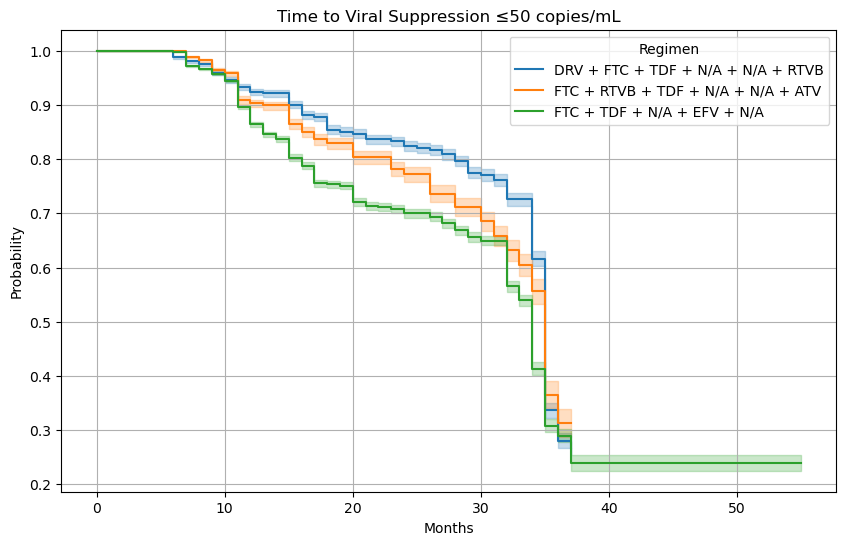

In [111]:
km('vl50')

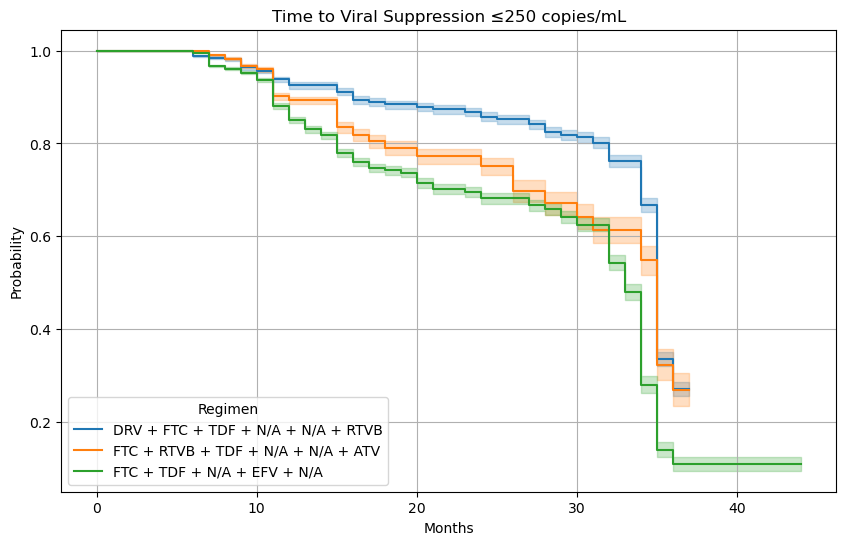

In [112]:
km('vl250')

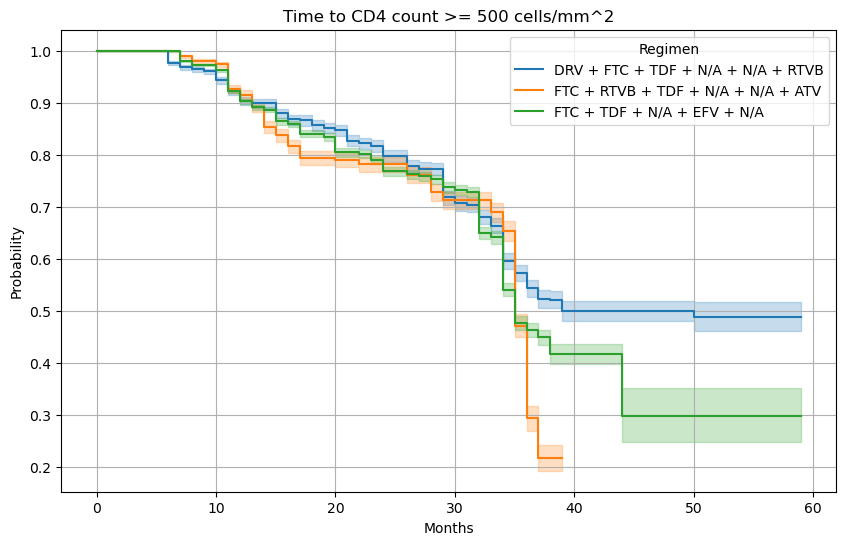

In [120]:
km('cd4_500')

In [182]:
def xgboost(mode):
    intervals_tmp = filter_intervals(intervals_censored, mode)
    # --- Feature 1: Regimen Components (One-Hot Encoded) ---
    regimen_components = intervals_tmp['Regimen'].str.get_dummies(sep=' + ')  # Split "FTC + TDF + DTG" into columns

    # --- Feature 2: Time-Based Features ---
    intervals_tmp['Duration_on_Regimen'] = intervals_tmp['End'] - intervals_tmp['Start']  # Months on regimen

    # --- Feature 3: Prior Regimen History ---
    # Count of prior regimens for the patient
    intervals_tmp['Prior_Regimen_Count'] = intervals_tmp.groupby('ID').cumcount()

    # --- Feature 4: Outcome Status in Prior Intervals ---
    # Did the patient fail/succeed in previous regimens?
    censor_col = 'VL_50_Censored' if mode == 'vl50' else 'VL_250_Censored' if mode == 'vl250' else 'CD4_500_Censored'
    intervals_tmp['Prior_Failure'] = intervals_tmp.groupby('ID')[censor_col].shift(1).fillna(False)

    # --- Feature 5: Baseline/Demographics ---
    baseline_features = ['Gender', 'Ethnicity', 'VL_50_baseline', 'CD4_500_baseline', 'CD4_Percent_baseline']

    # Combine all features
    X = pd.concat([regimen_components, intervals_tmp[['Duration_on_Regimen',
                                                'Prior_Regimen_Count', 'Prior_Failure'] + baseline_features]], axis=1)

    
    target_col = 'VL_50_time' if mode == 'vl50' else 'VL_250_time' if mode == 'vl250' else 'CD4_500_time'
    intervals_tmp['Target'] = (
        (intervals_tmp[target_col] - intervals_tmp['End'] <= 0) &  # Outcome within 6 months
        (~intervals_tmp[target_col].isna())                      # Exclude censored intervals
    ).astype(int)
    y = intervals_tmp['Target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    xgb.fit(X_train, y_train)

    xgb_probs = xgb.predict_proba(X_test)[:, 1]
    xgb_preds = xgb.predict(X_test)

    xgb_auc = roc_auc_score(y_test, xgb_probs)
    xgb_acc = accuracy_score(y_test, xgb_preds)

    print(xgb_auc, xgb_acc)

    return pd.DataFrame({
        'Feature': X.columns,
        'Importance': xgb.feature_importances_
    }).sort_values('Importance', ascending=False)



In [183]:
xgboost('vl50')[:10]

/var/folders/bw/5y6vvgld6yv27r1hv8xx5dq80000gn/T/ipykernel_3258/871672614.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  intervals_tmp['Prior_Failure'] = intervals_tmp.groupby('ID')[censor_col].shift(1).fillna(False)
/Users/matthew/anaconda3/envs/DeepLearning/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [05:18:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


0.9954393002740926 0.9700051210768893


,Feature,Importance
67,Duration_on_Regimen,0.404297
72,VL_50_baseline,0.153283
68,Prior_Regimen_Count,0.113615
71,Ethnicity,0.107570
70,Gender,0.082634
73,CD4_500_baseline,0.070174
74,CD4_Percent_baseline,0.068427
46,+ FTC + TDF + EVG + N/A + N/A + ExtraPK +,0.000000
51,+ FTC + TDF + N/A + N/A + LPV +,0.000000
50,+ FTC + TDF + N/A + N/A + ATV +,0.000000
